In [4]:
import pandas as pd
import numpy as np
from PIL import Image
import os

# Load the CSV containing image file names and ONSD measurements
df_measurements = pd.read_csv('./documents/processed_images/image_measurements.csv')

# Load and preprocess images
def load_and_preprocess_image(image_path):
    with Image.open(image_path) as img:
        img = img.resize((128, 128))  # Ensure all images are the same size
        return np.array(img).flatten()  # Flatten the image data

base_dir = './documents/processed_images'
image_data = np.array([load_and_preprocess_image(os.path.join(base_dir, filename)) for filename in df_measurements['image_filename']])
onsd_measurements = df_measurements['onsd_measurement'].values

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_data, onsd_measurements, test_size=0.2, random_state=42)


In [5]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Assuming X_train, y_train are your full training datasets

def objective_creator(X_train, y_train):
    def objective(trial):
        # Define the hyperparameter space
        params = {
            'objective': 'reg:squarederror',
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 9),
            'alpha': trial.suggest_float('alpha', 1, 10),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300)
        }
        
        # Split your dataset inside the objective function
        X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        
        # Initialize and train the model
        model = xgb.XGBRegressor(**params)
        model.fit(X_tr, y_tr)
        
        # Predict and calculate the mean squared error
        preds = model.predict(X_val)
        mse = mean_squared_error(y_val, preds)
        
        return mse
    return objective

objective = objective_creator(X_train, y_train)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)  # Feel free to adjust n_trials based on your computational constraints

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)


[I 2024-03-31 21:20:31,438] A new study created in memory with name: no-name-5a5b50ad-e334-4132-811a-02c4abb1e303


[I 2024-03-31 21:20:40,693] Trial 0 finished with value: 0.36736609474628906 and parameters: {'colsample_bytree': 0.40509443750566176, 'learning_rate': 0.1784815857535168, 'max_depth': 4, 'alpha': 7.994903633993186, 'n_estimators': 93}. Best is trial 0 with value: 0.36736609474628906.
[I 2024-03-31 21:20:51,582] Trial 1 finished with value: 0.44169561426485526 and parameters: {'colsample_bytree': 0.6507920579305806, 'learning_rate': 0.17533402238352586, 'max_depth': 9, 'alpha': 4.5604237049149505, 'n_estimators': 61}. Best is trial 0 with value: 0.36736609474628906.
[I 2024-03-31 21:21:02,965] Trial 2 finished with value: 0.4113196879441148 and parameters: {'colsample_bytree': 0.19440057400016242, 'learning_rate': 0.0960298030790556, 'max_depth': 8, 'alpha': 2.397033766461391, 'n_estimators': 146}. Best is trial 0 with value: 0.36736609474628906.
[I 2024-03-31 21:21:22,823] Trial 3 finished with value: 0.4096697140124213 and parameters: {'colsample_bytree': 0.5653838275399025, 'learnin

Number of finished trials: 100
Best trial: {'colsample_bytree': 0.8682188617193881, 'learning_rate': 0.0573245507838018, 'max_depth': 4, 'alpha': 6.252121841103143, 'n_estimators': 52}


In [6]:
best_params = study.best_trial.params
# Reinitialize the model with the best parameters
optimized_model = xgb.XGBRegressor(**best_params)
optimized_model.fit(X_train, y_train)  # Assuming X_train, y_train are your training data


XGBRegressor(alpha=6.252121841103143, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8682188617193881, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0573245507838018,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=52, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [7]:
from xgboost import XGBRegressor

# Initializing the model with the optimal parameters
optimized_model = XGBRegressor(
    alpha=6.252121841103143,
    colsample_bytree=0.8682188617193881,
    learning_rate=0.0573245507838018,
    max_depth=4,
    n_estimators=52
    # Include other optimal parameters as necessary
)

# Fit the model on your training data
optimized_model.fit(X_train, y_train)


XGBRegressor(alpha=6.252121841103143, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8682188617193881, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0573245507838018,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=52, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming X_test, y_test are your testing datasets

# Predict ONSD measurements on the test set using the optimized model
y_pred = optimized_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Display the metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Mean Squared Error (MSE): 0.4241
Mean Absolute Error (MAE): 0.5694
Root Mean Squared Error (RMSE): 0.6513


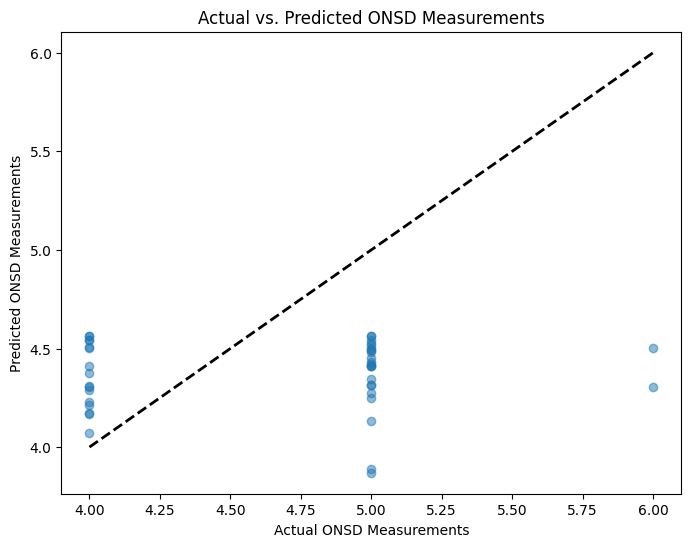

In [9]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs. predicted ONSD measurements
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for reference
plt.xlabel('Actual ONSD Measurements')
plt.ylabel('Predicted ONSD Measurements')
plt.title('Actual vs. Predicted ONSD Measurements')
plt.show()


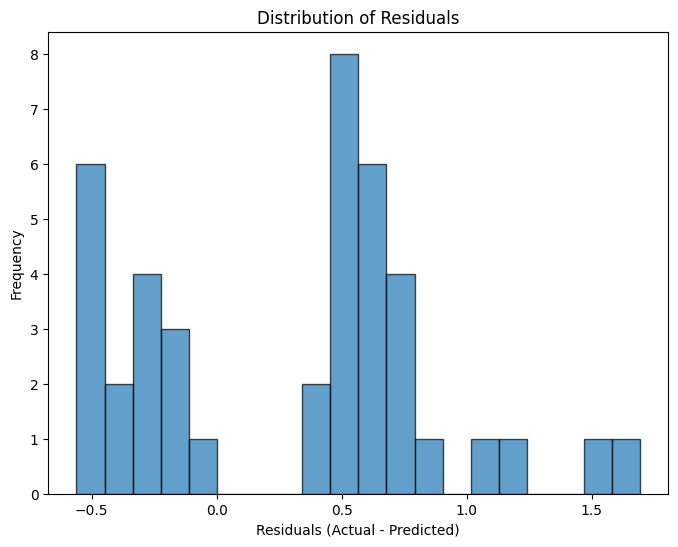

In [10]:
# Calculate the differences (residuals) between the actual and predicted values
residuals = y_test - y_pred

# Plotting the distribution of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()


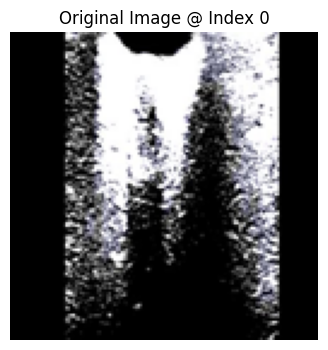

Actual ONSD Measurement: 6
Optimized XGBoost Predicted ONSD: 4.500457286834717


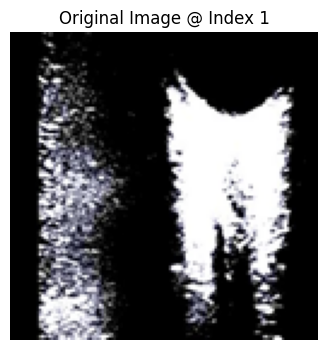

Actual ONSD Measurement: 4
Optimized XGBoost Predicted ONSD: 4.561747074127197


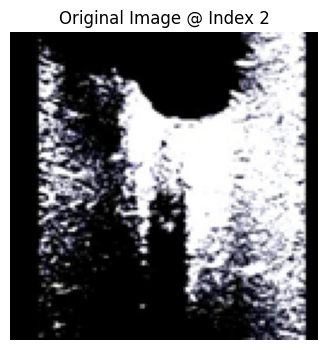

Actual ONSD Measurement: 4
Optimized XGBoost Predicted ONSD: 4.29159688949585


In [12]:
import matplotlib.pyplot as plt

# Assuming optimized_model is your trained XGBRegressor with optimal parameters

# Generate predictions for X_test using the optimized model
optimized_predictions = optimized_model.predict(X_test)

def display_image_with_optimized_xgb_measurements(index):
    # Ensure the image data is reshaped back to its original dimensions
    image = X_test[index].reshape(128, 128, 3)  # Adjust the reshape based on your original image size and channels
    
    actual_measurement = y_test[index]
    optimized_predicted_measurement = optimized_predictions[index]
    
    plt.figure(figsize=(6, 4))
    plt.imshow(image)
    plt.title(f"Original Image @ Index {index}")
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()
    
    print(f"Actual ONSD Measurement: {actual_measurement}")
    print(f"Optimized XGBoost Predicted ONSD: {optimized_predicted_measurement}")

# Display images with optimized XGBoost predictions for indexes 0, 1, 2 as examples
for index in [0, 1, 2]:
    display_image_with_optimized_xgb_measurements(index)
